# Step 1: Organize data

In [ ]:
import pandas as pd
import numpy as np
import nibabel as nib
import os

outdir = '/Users/catcamacho/Library/CloudStorage/Box-Box/CCP/HBN_study/proc/group/datasets/'
procdir = '/Users/catcamacho/Library/CloudStorage/Box-Box/CCP/HBN_study/proc/group/parcel_activation/parcel_activation'
infodir = '/Users/catcamacho/Library/CloudStorage/Box-Box/CCP/HBN_study/proc/group/datasets_info/'

motion = pd.read_csv(infodir + 'activation_usability20220102.csv', index_col=0)
pheno_data = pd.read_csv(infodir + 'HBN_MRI_DATA_TRACKER_20220102_movie.csv', index_col=0)
#thresholds = [ 0.8, 0.5, 0.9]
thresholds = [0.8]

In [ ]:
# convert handedness to integers
pheno_data.loc[:,'righthanded']=0
pheno_data.loc[pheno_data['EHQ_Total']>48,'righthanded']=1 # right handed

for thresh in thresholds:
    ## loop through and pull up usable data
    dataset_labels = open(outdir + 'firstleveldatalabels_thresh{0}_20220412.csv'.format(thresh), 'w')
    dataset_labels.write('sub,set,cond,movie,age,site,female,meanFD,righthanded\n')
    index = 0

    for sub in motion.index:
        for movie in ['TP','DM']:
            if motion.loc[sub, 'movie{0}_pcentlomo'.format(movie)] > thresh:
                for cond in ['positive','negative','brightness','loudness','speaking','whole_words']:
                    try:
                        temp = nib.load('{0}/{1}_movie{2}_general_{3}.pscalar.nii'.format(procdir, sub, movie, cond)).get_fdata()
                        if index==0:
                            data = temp
                        else:
                            data = np.concatenate([data, temp], axis=0)
                        dataset_labels.write('{0},general,{1},{2},{3},{4},{5},{6},{7}\n'.format(sub, cond, movie, pheno_data.loc[sub[4:], 'Age'],
                                                                                          pheno_data.loc[sub[4:], 'site'], pheno_data.loc[sub[4:], 'Sex'], 
                                                                                          motion.loc[sub, 'movie{0}_meanFD'.format(movie)],
                                                                                          pheno_data.loc[sub[4:], 'righthanded']))
                        index = index + 1
                    except:
                        print('WARNING: {0}/{1}_movie{2}_general_{3}.pscalar.nii not found.'.format(procdir, sub, movie, cond))

                for cond in ['anger','fear','excite','sad','happy','brightness','loudness']:
                    try:
                        temp = nib.load('{0}/{1}_movie{2}_specific_{3}.pscalar.nii'.format(procdir, sub, movie, cond)).get_fdata()
                        if index==0:
                            data = temp
                        else:
                            data = np.concatenate([data, temp], axis=0)
                        dataset_labels.write('{0},specific,{1},{2},{3},{4},{5},{6},{7}\n'.format(sub, cond, movie, pheno_data.loc[sub[4:], 'Age'],
                                                                                          pheno_data.loc[sub[4:], 'site'], pheno_data.loc[sub[4:], 'Sex'], 
                                                                                          motion.loc[sub, 'movie{0}_meanFD'.format(movie)],
                                                                                          pheno_data.loc[sub[4:], 'righthanded']))
                        index = index + 1
                    except:
                        print('WARNING: {0}/{1}_movie{2}_specific_{3}.pscalar.nii not found.'.format(procdir, sub, movie, cond))
                

    dataset_labels.close()
    np.save(outdir + 'firstleveldata_thresh{0}_20220412.npy'.format(thresh), data)

# Step 2: set up analysis functions and class

In [2]:
import pandas as pd
import numpy as np
import nibabel as nib
import os
import scipy.stats as scp
from sklearn.svm import SVC, SVR
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, mean_squared_error
from sklearn.model_selection import cross_validate, cross_val_predict, GroupKFold, permutation_test_score
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from datetime import date
import itertools
import random
from glob import glob

today = date.today().strftime('%Y%m%d')

In [3]:
def cv_fit(model, X, Y, groups, cv):
    
    if isinstance(model, SVC):
        scoring = 'accuracy'
    elif isinstance(model, SVR):
        scoring = 'neg_mean_squared_error'
    results = cross_validate(model, X=X, y=Y, groups=groups, n_jobs=10,
                       cv=cv, return_estimator=True, scoring=scoring)
    Y_pred = cross_val_predict(model, X=X, y=Y, groups=groups, n_jobs=10, cv=cv)
    train_scores = results['test_score']

    for i, a in enumerate(results['estimator']):
        c = np.expand_dims(a.coef_, axis=2)
        if i==0:
            weights = c
        else:
            weights = np.concatenate([weights, c], axis=2)
    
    estimators = results['estimator']
    weights = np.absolute(weights)
    mean_weights = np.mean(np.mean(weights, axis=2), axis=0, keepdims=True)
    return(estimators, weights, mean_weights, Y_pred, train_scores)

def cv_fit_poly(model, X, Y, groups, cv):
    
    if isinstance(model, SVC):
        scoring = 'accuracy'
    elif isinstance(model, SVR):
        scoring = 'neg_mean_squared_error'
    results = cross_validate(model, X=X, y=Y, groups=groups, n_jobs=10,
                       cv=cv, return_estimator=True, scoring=scoring)
    Y_pred = cross_val_predict(model, X=X, y=Y, groups=groups, n_jobs=10, cv=cv)
    train_scores = results['test_score']
    estimators = results['estimator']
    return(estimators, Y_pred, train_scores)


def bootstrap_train_score(model, X, Y, groups, cv, outdir, kind='classifier', ci=90, samples=10000):
    
    # determine percentiles for the CI estimation from the bootstrapped distribution
    lower = (100 - ci)/2
    upper = 100 - lower

    if isinstance(model, SVC):
        scoring = 'accuracy'
    elif isinstance(model, SVR):
        scoring = 'neg_mean_squared_error'

    train_scores = []
    corrcoeffs = []

    for a in range(0,samples):
        bootsample_size = random.randint(int(len(Y)*0.5),int(len(Y)*0.75))
        subsampmask = np.full(len(Y), 0)
        subsampmask[:bootsample_size] = 1
        np.random.shuffle(subsampmask)
        X_temp = X[subsampmask==1,:]
        Y_temp = Y[subsampmask==1]
        g_temp = groups[subsampmask==1]
        results = cross_validate(model, X=X_temp, y=Y_temp, groups=g_temp, n_jobs=10,
                                 cv=cv, return_estimator=False, scoring=scoring)
        train_scores.append(results['test_score'])

        if kind=='regress':
            Y_t = cross_val_predict(model, X=X_temp, y=Y_temp, groups=g_temp, n_jobs=10, cv=cv)
            r, p = scp.spearmanr(Y_temp, Y_t)
            corrcoeffs.append(r)

    # test if boot strapped distibution is normally distributed
    train_scores = np.concatenate(train_scores).flatten()
    k , p = scp.kstest(train_scores, 'norm')        

    # store and save results
    results = pd.DataFrame(columns = ['boot_mean','boot_SD','boot_median','KSstat','KSpval','CI','lowerCI','upperCI'])
    results.loc['train_scores','boot_mean'] = np.mean(train_scores)
    results.loc['train_scores','boot_SD'] = np.std(train_scores)
    results.loc['train_scores','boot_median'] = np.percentile(train_scores, 50)
    results.loc['train_scores','CI'] = ci
    results.loc['train_scores','lowerCI'] = np.percentile(train_scores, lower)
    results.loc['train_scores','upperCI'] = np.percentile(train_scores, upper)
    results.loc['train_scores','KSstat'] = k
    results.loc['train_scores','KSpval'] = p

    if kind=='regress':
        k , p = scp.kstest(corrcoeffs, 'norm')
        corrcoeffs = np.array(corrcoeffs)

        results.loc['pearsonr','boot_mean'] = np.mean(corrcoeffs)
        results.loc['pearsonr','boot_SD'] = np.std(corrcoeffs)
        results.loc['pearsonr','boot_median'] = np.percentile(corrcoeffs, 50)
        results.loc['pearsonr','CI'] = ci
        results.loc['pearsonr','lowerCI'] = np.percentile(corrcoeffs, lower)
        results.loc['pearsonr','upperCI'] = np.percentile(corrcoeffs, upper)
        results.loc['pearsonr','KSstat'] = k
        results.loc['pearsonr','KSpval'] = p

    results.to_csv(os.path.join(outdir, 'bootstrapped_training_accuracy_randN.csv'))

    return(results)


def predict_out(X, Y, estimators, kind):
    index = range(0,len(Y))
    for i, a in enumerate(estimators):
        if i==0:
            Y_pred = a.predict(X)
            Y_test = Y
            ind = index
        else:
            Y_pred = np.concatenate([Y_pred, a.predict(X)], axis=0)
            Y_test = np.concatenate([Y_test, Y], axis=0)
            ind = np.concatenate([ind, index], axis=0)

    if kind=='classifier':
        accuracy = pd.DataFrame.from_dict(classification_report(Y_test, Y_pred, output_dict=True)).T
    elif kind=='regress':
        var_series = pd.Series(Y_pred, index=ind)
        var_series = var_series.groupby(var_series.index).mean()
        accuracy = pd.DataFrame(columns = ['stat','pval'])
        Y_test = Y
        Y_pred = var_series.to_numpy()
        accuracy.loc['SpearmanR','stat'], accuracy.loc['SpearmanR','pval'] = scp.spearmanr(Y_pred, Y_test)
        accuracy.loc['PearsonR','stat'], accuracy.loc['PearsonR','pval'] = scp.pearsonr(Y_pred, Y_test)
        slope, intercept, r, p, se = scp.linregress(Y_pred, Y_test)
        accuracy.loc['LinearB','stat'] = slope
        accuracy.loc['LinearB','pval'] = p
        accuracy.loc['MSE','stat'] = mean_squared_error(Y_pred, Y_test)
    return(Y_pred, accuracy)


def boot_predict(estimators, X, Y, outdir, kind='classifier', ci=90, samples=10000):
    # determine percentiles for the CI estimation from the bootstrapped distribution
    lower = (100 - ci)/2
    upper = 100 - lower

    if isinstance(model, SVC):
        scoring = 'accuracy'
    elif isinstance(model, SVR):
        scoring = 'neg_mean_squared_error'

    test_scores = []
    pearsonr = []
    spearmanr = []

    for a in range(0,samples):
        
        bootsample_size = random.randint(int(len(Y)*0.5),int(len(Y)*0.75))
        subsampmask = np.full(len(Y), 0)
        subsampmask[:bootsample_size] = 1
        np.random.shuffle(subsampmask)
        X_temp = X[subsampmask==1,:]
        Y_temp = Y[subsampmask==1]

        for a in estimators:
            Y_pred = a.predict(X_temp)
            if kind=='classifier':
                t = classification_report(Y_temp, Y_pred, output_dict=True)
                test_scores.append(t['accuracy'])
            elif kind=='regress':
                mse = mean_squared_error(Y_temp, Y_pred)
                r, p = scp.spearmanr(Y_temp, Y_pred)
                test_scores.append(mse)
                spearmanr.append(r)
                r, p = scp.pearsonr(Y_temp, Y_pred)
                pearsonr.append(r)

    # test if boot strapped distibution is normally distributed
    test_scores = np.array(test_scores)
    k , p = scp.kstest(test_scores, 'norm')        

    # store and save results
    results = pd.DataFrame(columns = ['boot_mean','boot_SD','boot_median','KSstat','KSpval','CI','lowerCI','upperCI'])
    results.loc['test_scores','boot_mean'] = np.mean(test_scores)
    results.loc['test_scores','boot_SD'] = np.std(test_scores)
    results.loc['test_scores','boot_median'] = np.percentile(test_scores, 50)
    results.loc['test_scores','CI'] = ci
    results.loc['test_scores','lowerCI'] = np.percentile(test_scores, lower)
    results.loc['test_scores','upperCI'] = np.percentile(test_scores, upper)
    results.loc['test_scores','KSstat'] = k
    results.loc['test_scores','KSpval'] = p

    if kind=='regress':
        k , p = scp.kstest(spearmanr, 'norm')
        spearmanr = np.array(spearmanr)

        results.loc['spearmanr','boot_mean'] = np.mean(spearmanr)
        results.loc['spearmanr','boot_SD'] = np.std(spearmanr)
        results.loc['spearmanr','boot_median'] = np.percentile(spearmanr, 50)
        results.loc['spearmanr','CI'] = ci
        results.loc['spearmanr','lowerCI'] = np.percentile(spearmanr, lower)
        results.loc['spearmanr','upperCI'] = np.percentile(spearmanr, upper)
        results.loc['spearmanr','KSstat'] = k
        results.loc['spearmanr','KSpval'] = p

        k , p = scp.kstest(pearsonr, 'norm')
        pearsonr = np.array(pearsonr)

        results.loc['pearsonr','boot_mean'] = np.mean(pearsonr)
        results.loc['pearsonr','boot_SD'] = np.std(pearsonr)
        results.loc['pearsonr','boot_median'] = np.percentile(pearsonr, 50)
        results.loc['pearsonr','CI'] = ci
        results.loc['pearsonr','lowerCI'] = np.percentile(pearsonr, lower)
        results.loc['pearsonr','upperCI'] = np.percentile(pearsonr, upper)
        results.loc['pearsonr','KSstat'] = k
        results.loc['pearsonr','KSpval'] = p

    results.to_csv(os.path.join(outdir, 'bootstrapped_test_accuracy_randN.csv'))
    np.save(os.path.join(outdir, 'bootstrapped_test_scores_randN.npy'), test_scores)
    return(results)


def make_confusion_matrix(Y, Y_pred, folds, outfile_name):
    if Y.shape[0] < Y_pred.shape[0]:
        Y_orig = Y
        for i in range(1, folds):
            Y = np.concatenate([Y,Y_orig], axis=0)

    if Y.shape[0] == Y_pred.shape[0]:
        fig = ConfusionMatrixDisplay.from_predictions(Y, Y_pred, normalize='all', xticks_rotation='vertical', 
                                                      include_values=False)
        plt.tight_layout()
        plt.savefig('{0}_{1}.svg'.format(outfile_name, today))
    else:
        print("ERROR: length mismatch")    

        
def make_consistency_plot(Y, Y_pred, folds, outfile_name):
    if Y.shape[0] < Y_pred.shape[0]:
        Y_orig = Y
        for i in range(1, folds):
            Y = np.concatenate([Y,Y_orig], axis=0)

    if Y.shape[0] == Y_pred.shape[0]:
        plt.figure(figsize=(4,3))
        plt.scatter(Y, Y_pred)
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.tight_layout()
        plt.savefig('{0}_{1}.svg'.format(outfile_name, today))
    else:
        print("ERROR: length mismatch")    
        
        
def make_cifti_weights(weights, mean_weights, sample_file, out_prefix):
    if weights.ndim==3:
        weights = np.mean(weights, axis=2)
    
    ax0 = nib.cifti2.cifti2_axes.SeriesAxis(0,1,weights.shape[0], unit='second')
    ax1 = nib.load(sample_file).header.get_axis(1)
    weights_img = nib.cifti2.cifti2.Cifti2Image(weights, (ax0, ax1))
    nib.save( weights_img, '{0}_SVM_weights_{1}.ptseries.nii'.format(out_prefix,today))

    ax0 = nib.load(sample_file).header.get_axis(0)
    ax1 = nib.load(sample_file).header.get_axis(1)
    weights_img = nib.cifti2.cifti2.Cifti2Image(np.expand_dims(np.mean(mean_weights, axis=0), axis=0), (ax0, ax1))
    nib.save( weights_img, '{0}_SVC_weights_mean_{1}.pscalar.nii'.format(out_prefix, today))

    
def create_mean_act_files(X, Y, sample_file, weights, out_folder, kind):
    ax0 = nib.load(sample_file).header.get_axis(0)
    ax1 = nib.load(sample_file).header.get_axis(1)
    
    weight_table = pd.DataFrame(index=ax1.name)
    weight_table['mean_weight'] = np.squeeze(weights)
    
    if kind=='classifier':
        activation = pd.DataFrame(X, columns = ax1.name, index=Y)
        mean_act = activation.groupby(by=activation.index, axis=0).mean()
        weight_table[mean_act.index] = mean_act.T
        for a in mean_act.index:
            img = nib.cifti2.cifti2.Cifti2Image(np.expand_dims(mean_act.loc[a,:], axis=0), (ax0, ax1))
            nib.save(img, '{0}mean_activation_{1}_{2}.pscalar.nii'.format(out_folder, a, today))
        
        weight_table.to_csv('{0}weights_activation_table_{1}.csv'.format(out_folder, today))
            
        
def permuted_p(model, X, Y, cv, groups, out_folder, train_score, test_score, n_perms=1000):

    # Perform permutation testing to get a p-value
    scoring = 'accuracy'
    if isinstance(Y, pd.Series):
        Y = Y.to_numpy()

    Y_shuff = Y
    scores = np.zeros((n_perms, cv.n_splits))
    for a in range(0,n_perms):
        np.random.shuffle(Y_shuff)
        res = cross_validate(model, X=X, y=Y_shuff, groups=groups, n_jobs=10, cv=cv, scoring=scoring)
        scores[a,:] = res['test_score']
    permutation_scores = scores.flatten()
    pvalue=(np.sum((permutation_scores>=test_score).astype(int)) + 1) / (n_perms*cv.n_splits + 1)
        
    # Save a figure of the permutation scores
    fig, ax = plt.subplots(figsize=(4,3))
    ax.hist(permutation_scores, 20, label='Permutation scores', density=True)
    ax.axvline(train_score, ls='-', color='m', label='Train')
    ax.axvline(test_score, ls='--', color='g', label='Test')
    if isinstance(model, SVC):
        ax.axvline(1. / len(np.unique(Y_train)), ls='--', color='k', label='Chance')   
    plt.legend()
    plt.xlabel('Score')
    plt.tight_layout()
    plt.savefig('{0}permutation_plot_{1}.svg'.format(out_folder, today), transparent=True)
    plt.close()

    # Save scores as a csv
    results = pd.DataFrame()
    results.loc['Train_Score','Stat'] = train_score
    results.loc['Test_Score','Stat'] = test_score
    results.loc['Train_Score','PermPval'] = (np.sum((permutation_scores>=train_score).astype(int)) + 1) / (n_perms*cv.n_splits + 1)
    results.loc['Test_Score','PermPval'] = pvalue
    results.to_csv('{0}permutation_stats.csv'.format(out_folder))
    return(pvalue, permutation_scores)

def permuted_importance(estimators_list, X, Y, sample_file, out_folder):
    results = []
    if isinstance(estimators_list[0], SVC):
        scoring = 'accuracy'
    elif isinstance(estimators_list[0], SVR):
        scoring = 'neg_mean_squared_error'
    
    for a in estimators_list:
        r = permutation_importance(a, X, Y, scoring=scoring, n_repeats=100, n_jobs=10, random_state=42)
        results.append(r)

    for i, r in enumerate(results):
        if i==0:
            imp_scores = r['importances'].T
        else:
            imp_scores = np.concatenate([imp_scores, r['importances'].T], axis=0)
    
    # save CIFTI with mean importance scores
    ax0 = nib.load(sample_file).header.get_axis(0)
    ax1 = nib.load(sample_file).header.get_axis(1)
    impciftidata = np.expand_dims(np.mean(imp_scores, axis=0), axis=0)
    img = nib.cifti2.cifti2.Cifti2Image(impciftidata, (ax0, ax1))
    nib.save(img, '{0}mean_permuted_importance_scores_{1}.pscalar.nii'.format(out_folder, today))
    
    # save dataframe with all the scores
    imp_score_table = pd.DataFrame(imp_scores.T, index=ax1.name)
    imp_score_table.to_csv('{0}permuted_importance_scores_{1}.csv'.format(out_folder, today))
    
    # save dataframe with mean scores
    imp_mean=np.mean(imp_scores, axis=0, keepdims=True)
    imp_table = pd.DataFrame(index=ax1.name)
    imp_table['mean_importance'] = np.squeeze(imp_mean)
    imp_table.to_csv('{0}mean_importance_{1}.csv'.format(out_folder, today))

    # plot importance scores
    imp_table['region'] = imp_table.index
    sorted_imp_table = imp_table.sort_values(by='mean_importance', axis=0, ascending=False)
    plt.figure(figsize=(6,5))
    sns.barplot(x='mean_importance', y='region', data=sorted_imp_table.iloc[:20,:], ci=None, color="#3B75AF")
    plt.xlabel('Change in {0}'.format(scoring))
    plt.ylabel('')
    plt.axvline(0, color='gray', clip_on=False)
    sns.despine()
    plt.tight_layout()
    plt.savefig('{0}top20importance_{1}.svg'.format(out_folder, today))
    
def permuted_network_importance(model, X, Y, sample_file, out_folder, model_score, n_perms=500):
    if isinstance(model, SVC):
        scoring = 'accuracy'
    elif isinstance(model, SVR):
        scoring = 'neg_mean_squared_error'
    
    # get network names and sizes
    parcel_labels = nib.load(sample_file).header.get_axis(1).name
    network_labels = []
    for s in parcel_labels:
        b = s.split('_')
        if len(b)<2:
            network_labels.append(b[0])
        else:
            network_labels.append(b[1])
    network_labels = np.array(network_labels)
    network_names, network_sizes = np.unique(network_labels, return_counts=True)
    
    # set up permutations
    np.save(out_folder + 'temp.npy', X)
    rng = np.random.default_rng()
    perm_net_imp = pd.DataFrame(index=network_names, columns=range(0,n_perms))
    perm_netrand_imp = pd.DataFrame(index=network_names, columns=range(0,n_perms))
    model_score = np.mean(model_score)

    for i in range(0,n_perms):
        for net in network_names:
            # permute only the network-specific features
            net_perm_X = np.load(out_folder + 'temp.npy')
            netperm = net_perm_X[:,network_labels==net]
            netperm = rng.permutation(rng.permutation(netperm, axis=0), axis=1)
            net_perm_X[:,network_labels==net] = netperm
            results = cross_validate(model, X=net_perm_X, y=Y, groups=groups, n_jobs=10, cv=cv, scoring=scoring)
            perm_imp = model_score - np.mean(results['test_score'])
            perm_net_imp.loc[net,i] = perm_imp

        for n, count in enumerate(network_sizes):
            mask = np.full(X.shape[1], 0)
            mask[:count] = 1
            np.random.shuffle(mask)
            net_perm_X = np.load(out_folder + 'temp.npy')
            net_perm_X[:,mask] = rng.permutation(rng.permutation(X[:,mask], axis=0), axis=1)
            results = cross_validate(model, X=net_perm_X, y=Y, groups=groups, n_jobs=10, cv=cv, scoring=scoring)
            perm_imp = model_score - np.mean(results['test_score'])
            perm_netrand_imp.loc[network_names[n],i] = perm_imp

    os.remove(out_folder + 'temp.npy')
    
    # Reorder the networks by mean permuted importance
    imp_table = perm_net_imp.mean(axis=1).to_frame(name='mean_importance')
    sorted_imp_table = imp_table.sort_values(by='mean_importance', axis=0, ascending=False)
    neworder = sorted_imp_table.index

    # reorder dataframes
    perm_netrand_imp_reord = perm_netrand_imp.reindex(neworder).iloc[:20,:]
    perm_net_imp_reord = perm_net_imp.reindex(neworder).iloc[:20,:]

    # convert to long format
    idvars = perm_netrand_imp_reord.columns
    perm_netrand_imp_reord['networks'] = perm_netrand_imp_reord.index
    temp_randperm = pd.melt(perm_netrand_imp_reord, id_vars=['networks'], value_vars=idvars, var_name='iter', value_name='perm_change_score')

    idvars = perm_net_imp.columns
    perm_net_imp_reord['networks'] = perm_net_imp_reord.index
    temp_perm = pd.melt(perm_net_imp_reord, id_vars=['networks'], value_vars=idvars, var_name='iter', value_name='perm_change_score')

    # Initialize figure
    f, ax = plt.subplots(figsize=(7, 7))

    # Plot the actual permuted values
    sns.boxenplot(x="perm_change_score", y="networks", data=temp_perm, 
                  color='#9370DB', showfliers=False)

    # Plot the null distributions
    sns.boxenplot(x="perm_change_score", y="networks", data=temp_randperm,
                   color='darkgray', showfliers=False)

    # Tweak the visual presentation and save
    ax.xaxis.grid(True)
    ax.set(ylabel="")
    sns.despine()
    plt.tight_layout()
    plt.savefig('{0}perm_N1_importance_{1}.svg'.format(out_folder, today))

    return(perm_net_imp, perm_netrand_imp)
    
def permuted_N_networks_importance(model, X, Y, N, sample_file, out_folder, model_score, n_perms=500):
    if isinstance(model, SVC):
        scoring = 'accuracy'
    elif isinstance(model, SVR):
        scoring = 'neg_mean_squared_error'
    
    # get network names and sizes
    parcel_labels = nib.load(sample_file).header.get_axis(1).name
    network_labels = []
    for s in parcel_labels:
        b = s.split('_')
        if len(b)<2:
            network_labels.append(b[0])
        else:
            network_labels.append(b[1])
    network_labels = np.array(network_labels)
    network_names, network_sizes = np.unique(network_labels, return_counts=True)
    
    # set up permutations
    np.save(out_folder + 'temp.npy', X)
    rng = np.random.default_rng()
    perm_net_imp = pd.DataFrame(columns=range(0,n_perms))
    perm_netrand_imp = pd.DataFrame(columns=range(0,n_perms))
    model_score = np.mean(model_score)
    combs = itertools.combinations(network_names, N)

    for nets in combs:
        for i in range(0,n_perms):
            # permute only the network-specific features
            net_perm_X = pd.DataFrame(np.load(out_folder + 'temp.npy'), columns=network_labels)
            netperm = net_perm_X.loc[:,nets]
            netperm = rng.permutation(rng.permutation(netperm, axis=0), axis=1)
            net_perm_X.loc[:,nets] = netperm
            results = cross_validate(model, X=net_perm_X, y=Y, groups=groups, n_jobs=15, cv=cv, scoring=scoring)
            perm_imp = model_score - np.mean(results['test_score'])
            perm_net_imp.loc['{0}'.format(nets),i] = perm_imp

            mask = np.full(X.shape[1], 0)
            mask[:netperm.shape[1]] = 1
            np.random.shuffle(mask)
            net_perm_X = np.load(out_folder + 'temp.npy')
            net_perm_X[:,mask] = rng.permutation(rng.permutation(X[:,mask], axis=0), axis=1)
            results = cross_validate(model, X=net_perm_X, y=Y, groups=groups, n_jobs=15, cv=cv, scoring=scoring)
            perm_imp = model_score - np.mean(results['test_score'])
            perm_netrand_imp.loc['{0}'.format(nets),i] = perm_imp

    os.remove(out_folder + 'temp.npy')
    
    # Reorder the networks by mean permuted importance
    imp_table = perm_net_imp.mean(axis=1).to_frame(name='mean_importance')
    sorted_imp_table = imp_table.sort_values(by='mean_importance', axis=0, ascending=False)
    neworder = sorted_imp_table.index

    # reorder dataframes and drop to only top 20 means
    perm_netrand_imp_reord = perm_netrand_imp.reindex(neworder).iloc[:20,:]
    perm_net_imp_reord = perm_net_imp.reindex(neworder).iloc[:20,:]

    # convert to long format
    idvars = perm_netrand_imp_reord.columns
    perm_netrand_imp_reord['networks'] = perm_netrand_imp_reord.index
    temp_randperm = pd.melt(perm_netrand_imp_reord, id_vars=['networks'], value_vars=idvars, var_name='iter', value_name='perm_change_score')

    idvars = perm_net_imp.columns
    perm_net_imp_reord['networks'] = perm_net_imp_reord.index
    temp_perm = pd.melt(perm_net_imp_reord, id_vars=['networks'], value_vars=idvars, var_name='iter', value_name='perm_change_score')

    # Initialize figure
    f, ax = plt.subplots(figsize=(7, 7))

    # Plot the actual permuted values
    sns.boxenplot(x="perm_change_score", y="networks", data=temp_perm, 
                  color='#9370DB', showfliers=False)

    # Plot the null distributions
    sns.boxenplot(x="perm_change_score", y="networks", data=temp_randperm,
                   color='darkgray', showfliers=False)

    # Tweak the visual presentation and save
    ax.xaxis.grid(True)
    ax.set(ylabel="")
    sns.despine()
    plt.tight_layout()
    plt.savefig('{0}perm_N{1}_importance_{2}.svg'.format(out_folder, N, today))
    
    return(perm_net_imp, perm_netrand_imp)

In [4]:
## make class to handle model fitting
class permutedSVM:
    def __init__(self, model, cv, output_folder, folds=10, perm_iters=1000):
        self.cv = cv
        self.folds = folds
        self.perm_iters = perm_iters
        self.outfolder = output_folder
        self.random_state = model.random_state
        self.parcel_labels = None
        self.network_labels = None
        self.groups = None
        self.X_train = None
        self.Y_train = None
        self.bootstrap_train = None
        self.X_test = None
        self.Y_test = None
        self.boostrap_test = None
        self.model = model
        self.estimators = None
        self.weights = None
        self.mean_weights = None
        self.Y_test_pred = None
        self.Y_train_pred = None
        self.test_score = None
        self.template_outfile = None
        self.perm_pval = None
        self.perm_scores = None
        self.train_scores = None
        self.net_perms = None
        self.net_null_perms = None
        self.N_net_perms = None
        self.N_net_null_perms = None
        
        os.makedirs(output_folder, exist_ok=True)

    def fit(self, X_train, Y_train, groups, kernel='linear'):
        self.X_train = X_train
        self.Y_train = Y_train
        self.groups = groups 
        if kernel=='linear':
            estimators, weights, mean_weights, Y_pred, train_scores = cv_fit(self.model, self.X_train, self.Y_train, self.groups, self.cv)
            self.estimators = estimators
            self.weights = weights
            self.mean_weights = mean_weights
            self.Y_train_pred = Y_pred
            self.train_scores = train_scores
        elif kernel=='poly':
            estimators, Y_pred, train_scores = cv_fit_poly(self.model, self.X_train, self.Y_train, self.groups, self.cv)
            self.estimators = estimators
            self.Y_train_pred = Y_pred
            self.train_scores = train_scores
            
        with open(os.path.join(self.outfolder,'insample_accuracy.txt'), 'w') as f:
            f.write(str(np.mean(self.train_scores)))
        return(self)
    
    def boot_fit(self, kind='classifier', ci=90, boot_samples=10000):
        results = bootstrap_train_score(self.model, self.X_train, self.Y_train, self.groups, self.cv, self.outfolder, 
                                        kind=kind, ci=ci, samples=boot_samples)
        self.bootstrap_train = results
        return(self)
    
    def predict(self, X_test, Y_test, kind='classifier'):
        self.X_test = X_test
        self.Y_test = Y_test
        Y_pred, accuracy = predict_out(self.X_test, self.Y_test, self.estimators, kind=kind)
        self.Y_test_pred = Y_pred
        self.test_score = accuracy
        accuracy.to_csv(self.outfolder + 'performance_report.csv')
        return(self)
    
    def boot_predict(self, kind='classifier', ci=90, boot_samples=10000):
        results = boot_predict(self.estimators, self.X_test, self.Y_test, self.outfolder, kind=kind, ci=ci, samples=boot_samples)
        self.bootstrap_test = results
        return(self)

    def plot_confusion(self, outfile_name='confusion_matrix'):
        make_confusion_matrix(self.Y_test, self.Y_test_pred, self.folds, self.outfolder + outfile_name)
    
    def plot_consistency(self, outfile_name='consistency_plot'):
        make_consistency_plot(self.Y_test, self.Y_test_pred, self.folds, self.outfolder + outfile_name)
    
    def plot_weights(self, template_outfile, out_prefix='model'):
        self.template_outfile = template_outfile
        make_cifti_weights(self.weights, self.mean_weights, self.template_outfile, self.outfolder + out_prefix)
        
    def make_weights_table_img(self, kind='classifier'):
        create_mean_act_files(self.X_train, self.Y_train, self.template_outfile, self.mean_weights, self.outfolder, kind)
        
    def calc_permuted_pvalue(self, kind='classifier'):
        if kind=='classifier':
            test_acc = self.test_score.loc['accuracy','precision']
            train_acc = np.mean(self.train_scores)
        elif kind=='regress':
            test_acc = -svc.test_score.loc['MSE','stat']
            train_acc = np.mean(self.train_scores)
        pvalue, permutation_scores = permuted_p(self.model, self.X_train, self.Y_train, self.cv, self.groups, self.outfolder, train_acc, test_acc, n_perms=self.perm_iters)
        self.perm_pval = pvalue
        self.perm_scores = permutation_scores
        np.save(self.outfolder + 'permutation_scores.npy', permutation_scores)
        return(self)
    
    def get_perm_importance(self):
        permuted_importance(self.estimators, self.X_train, self.Y_train, self.template_outfile, self.outfolder)
        
    def get_perm_net_importance(self, n_perms=500):
        perm_net_imp, perm_netrand_imp = permuted_network_importance(self.model, self.X_train, self.Y_train, self.template_outfile, self.outfolder, self.train_scores, n_perms)
        self.net_perms = perm_net_imp
        perm_net_imp.to_csv(self.outfolder+'perm_N1_net_imp.csv')
        self.net_null_perms = perm_netrand_imp
        perm_netrand_imp.to_csv(self.outfolder+'perm_N1_randnet_imp.csv')
        return(self)
        
    def get_perm_N_net_importance(self, N, n_perms=500):
        perm_net_imp, perm_netrand_imp = permuted_N_networks_importance(self.model, self.X_train, self.Y_train, N, self.template_outfile, self.outfolder, self.train_scores, n_perms)
        self.N_net_perms = perm_net_imp
        perm_net_imp.to_csv(self.outfolder+'perm_N{0}_net_imp.csv'.format(N))
        self.N_net_null_perms = perm_netrand_imp
        perm_netrand_imp.to_csv(self.outfolder+'perm_N{0}_randnet_imp.csv'.format(N))
        return(self)

# Step 3: Conduct Analyses

## load data and set model params

In [5]:
## model parameters
thresh=0.8
folds = 10
cv = GroupKFold(n_splits=folds)
perm_iters = 1000
random_state = 42
model = SVC(kernel='linear', random_state=random_state)

## load model data
project_dir = '/Users/catcamacho/Library/CloudStorage/Box-Box/CCP/HBN_study/proc/group/'
data_dir = project_dir + '/datasets/'
out_dir = project_dir + 'SVM_results/thresh{0}/cond_analysis/'.format(thresh)
os.makedirs(out_dir,exist_ok=True)
sample_file = project_dir + 'datasets_info/sample_gord.32k_fs_LR.pscalar.nii'
data = np.load(data_dir + 'firstleveldata_thresh{0}_20220412.npy'.format(thresh))
data_labels = pd.read_csv(data_dir + 'firstleveldatalabels_thresh{0}_20220412.csv'.format(thresh), index_col=None)

# split training and testing data by site
full_train = data[data_labels['site']=='rubic']
full_train_labels = data_labels[data_labels['site']=='rubic']
full_test = data[data_labels['site']=='cbic']
full_test_labels = data_labels[data_labels['site']=='cbic']

# get network labels
parcel_labels = nib.load(sample_file).header.get_axis(1).name
network_labels = []
for s in parcel_labels:
    b = s.split('_')
    if len(b)<2:
        network_labels.append(b[0])
    else:
        network_labels.append(b[1])
network_labels = np.array(network_labels)
network_names, network_sizes = np.unique(network_labels, return_counts=True)

## Test: Can we discriminate emotion labels based on activation?

In [6]:
dataset = 'emo'

# discriminate between general emotions
X_train = full_train[((full_train_labels['cond']=='positive') | (full_train_labels['cond']=='negative'))]
Y_train = full_train_labels['cond'][((full_train_labels['cond']=='positive') | (full_train_labels['cond']=='negative'))]
groups = full_train_labels['sub'][((full_train_labels['cond']=='positive') | (full_train_labels['cond']=='negative'))]
X_test = full_test[((full_test_labels['cond']=='positive') | (full_test_labels['cond']=='negative'))]
Y_test =full_test_labels['cond'][((full_test_labels['cond']=='positive') | (full_test_labels['cond']=='negative'))]
out_folder = out_dir+'general_data-{0}/'.format(dataset)

svc = permutedSVM(model=model, cv=cv, output_folder=out_folder)
svc = svc.fit(X_train, Y_train, groups)
svc = svc.predict(X_test, Y_test)
svc.plot_weights(sample_file)
svc.make_weights_table_img()
#svc.boot_fit(ci=95, boot_samples=1000)
#svc.boot_predict(ci=95, boot_samples=1000)
#svc.plot_confusion()

#svc.calc_permuted_pvalue()
#svc.get_perm_importance()
#svc.get_perm_net_importance(n_perms=perm_iters)

# discriminate between specific emotions
X_train = full_train[((full_train_labels['cond']=='anger') | (full_train_labels['cond']=='happy') | \
                      (full_train_labels['cond']=='sad') | (full_train_labels['cond']=='fear')| (full_train_labels['cond']=='excite'))]
Y_train = full_train_labels['cond'][((full_train_labels['cond']=='anger') | (full_train_labels['cond']=='happy') \
                                     | (full_train_labels['cond']=='sad') | (full_train_labels['cond']=='fear')| (full_train_labels['cond']=='excite'))]
groups = full_train_labels['sub'][((full_train_labels['cond']=='anger') | (full_train_labels['cond']=='happy') \
                                   | (full_train_labels['cond']=='sad') | (full_train_labels['cond']=='fear')| (full_train_labels['cond']=='excite'))]
X_test = full_test[((full_test_labels['cond']=='anger') | (full_test_labels['cond']=='happy') | \
                    (full_test_labels['cond']=='sad') | (full_test_labels['cond']=='fear')| (full_test_labels['cond']=='excite'))]
Y_test =full_test_labels['cond'][((full_test_labels['cond']=='anger') | (full_test_labels['cond']=='happy') \
                                  | (full_test_labels['cond']=='sad') | (full_test_labels['cond']=='fear')| (full_test_labels['cond']=='excite'))]
out_folder = out_dir+'specific_data-{0}/'.format(dataset)

svc = permutedSVM(model=model, cv=cv, output_folder=out_folder)
svc = svc.fit(X_train, Y_train, groups)
svc = svc.predict(X_test, Y_test)
svc.plot_weights(sample_file)
svc.make_weights_table_img()
#svc.boot_fit(ci=95, boot_samples=1000)
#svc.boot_predict(ci=95, boot_samples=1000)
#svc.plot_confusion()

#svc.calc_permuted_pvalue()
#svc.get_perm_importance()
#svc.get_perm_net_importance(n_perms=1000)


## What networks are sufficient to discriminate emotion labels?

### Using real data

In [ ]:
# test if activation from specific networks/regions are sufficient for predicting emotions
dataset = 'emo'

for net in network_names:
    # general emotions
    X_train = full_train[((full_train_labels['cond']=='positive') | (full_train_labels['cond']=='negative'))][:, network_labels==net]
    Y_train = full_train_labels['cond'][((full_train_labels['cond']=='positive') | (full_train_labels['cond']=='negative'))]
    groups = full_train_labels['sub'][((full_train_labels['cond']=='positive') | (full_train_labels['cond']=='negative'))]
    X_test = full_test[((full_test_labels['cond']=='positive') | (full_test_labels['cond']=='negative'))][:, network_labels==net]
    Y_test =full_test_labels['cond'][((full_test_labels['cond']=='positive') | (full_test_labels['cond']=='negative'))]
    out_folder = out_dir+'general_data-{0}/net{1}/'.format(dataset, net)

    svc = permutedSVM(model=model, cv=cv, output_folder=out_folder)
    svc = svc.fit(X_train, Y_train, groups)
    svc = svc.predict(X_test, Y_test)
    svc.boot_predict(ci=95, boot_samples=1000)
    svc.plot_confusion()
    plt.close()
    
    # specific emotions
    X_train = full_train[((full_train_labels['cond']=='anger') | (full_train_labels['cond']=='happy') | \
                          (full_train_labels['cond']=='sad') | (full_train_labels['cond']=='fear')| (full_train_labels['cond']=='excite'))][:, network_labels==net]
    Y_train = full_train_labels['cond'][((full_train_labels['cond']=='anger') | (full_train_labels['cond']=='happy') \
                                         | (full_train_labels['cond']=='sad') | (full_train_labels['cond']=='fear')| (full_train_labels['cond']=='excite'))]
    groups = full_train_labels['sub'][((full_train_labels['cond']=='anger') | (full_train_labels['cond']=='happy') \
                                       | (full_train_labels['cond']=='sad') | (full_train_labels['cond']=='fear')| (full_train_labels['cond']=='excite'))]
    X_test = full_test[((full_test_labels['cond']=='anger') | (full_test_labels['cond']=='happy') | \
                        (full_test_labels['cond']=='sad') | (full_test_labels['cond']=='fear')| (full_test_labels['cond']=='excite'))][:, network_labels==net]
    Y_test =full_test_labels['cond'][((full_test_labels['cond']=='anger') | (full_test_labels['cond']=='happy') \
                                      | (full_test_labels['cond']=='sad') | (full_test_labels['cond']=='fear')| (full_test_labels['cond']=='excite'))]
    out_folder = out_dir+'specific_data-{0}/net{1}/'.format(dataset, net)

    svc = permutedSVM(model=model, cv=cv, output_folder=out_folder)
    svc = svc.fit(X_train, Y_train, groups)
    svc = svc.predict(X_test, Y_test)
    svc.boot_predict(ci=95, boot_samples=1000)
    svc.plot_confusion()
    plt.close()

### Using random parcels of net size

In [ ]:
dataset = 'emo'
for net in network_names[:1]:
    for i in range(0,900):
        mask = np.zeros(network_labels.shape)
        netsize = np.sum((network_labels==net).astype(int))
        mask[:netsize] = 1
        np.random.shuffle(mask)
        
        # general emotions
        X_train = full_train[((full_train_labels['cond']=='positive') | (full_train_labels['cond']=='negative'))][:, mask==1]
        Y_train = full_train_labels['cond'][((full_train_labels['cond']=='positive') | (full_train_labels['cond']=='negative'))]
        groups = full_train_labels['sub'][((full_train_labels['cond']=='positive') | (full_train_labels['cond']=='negative'))]
        X_test = full_test[((full_test_labels['cond']=='positive') | (full_test_labels['cond']=='negative'))][:, mask==1]
        Y_test =full_test_labels['cond'][((full_test_labels['cond']=='positive') | (full_test_labels['cond']=='negative'))]
        out_folder = out_dir+'general_data-{0}/net{1}/nulls/null0{2}/'.format(dataset, net, i)

        svc = permutedSVM(model=model, cv=cv, output_folder=out_folder)
        svc = svc.fit(X_train, Y_train, groups)
        svc = svc.predict(X_test, Y_test)
        svc.boot_predict(ci=95, boot_samples=10)
        

        # specific emotions
        X_train = full_train[((full_train_labels['cond']=='anger') | (full_train_labels['cond']=='happy') | \
                              (full_train_labels['cond']=='sad') | (full_train_labels['cond']=='fear')| (full_train_labels['cond']=='excite'))][:, mask==1]
        Y_train = full_train_labels['cond'][((full_train_labels['cond']=='anger') | (full_train_labels['cond']=='happy') \
                                             | (full_train_labels['cond']=='sad') | (full_train_labels['cond']=='fear')| (full_train_labels['cond']=='excite'))]
        groups = full_train_labels['sub'][((full_train_labels['cond']=='anger') | (full_train_labels['cond']=='happy') \
                                           | (full_train_labels['cond']=='sad') | (full_train_labels['cond']=='fear')| (full_train_labels['cond']=='excite'))]
        X_test = full_test[((full_test_labels['cond']=='anger') | (full_test_labels['cond']=='happy') | \
                            (full_test_labels['cond']=='sad') | (full_test_labels['cond']=='fear')| (full_test_labels['cond']=='excite'))][:, mask==1]
        Y_test =full_test_labels['cond'][((full_test_labels['cond']=='anger') | (full_test_labels['cond']=='happy') \
                                          | (full_test_labels['cond']=='sad') | (full_test_labels['cond']=='fear')| (full_test_labels['cond']=='excite'))]
        out_folder = out_dir+'specific_data-{0}/net{1}/nulls/null0{2}/'.format(dataset, net, i)

        svc = permutedSVM(model=model, cv=cv, output_folder=out_folder)
        svc = svc.fit(X_train, Y_train, groups)
        svc = svc.predict(X_test, Y_test)
        svc.boot_predict(ci=95, boot_samples=10)

for net in network_names:
    # compile bootstrapped results
    for emo in ['general','specific']:
        test_score_files = glob(out_dir+'{0}_data-emo/net{1}/nulls/*/bootstrapped_test_scores_randN.npy'.format(emo,net))
        test_scores = np.load(test_score_files[0])
        for i in range(1,len(test_score_files)):
            t = np.load(test_score_files[i])
            test_scores=np.concatenate((test_scores, t), axis=None)
        k , p = scp.kstest(test_scores, 'norm')        

        # store and save results
        results = pd.DataFrame(columns = ['boot_mean','boot_SD','boot_median','KSstat','KSpval','CI','lowerCI','upperCI'])
        results.loc['test_scores','boot_mean'] = np.mean(test_scores)
        results.loc['test_scores','boot_SD'] = np.std(test_scores)
        results.loc['test_scores','boot_median'] = np.percentile(test_scores, 50)
        results.loc['test_scores','CI'] = 95
        results.loc['test_scores','lowerCI'] = np.percentile(test_scores, 2.5)
        results.loc['test_scores','upperCI'] = np.percentile(test_scores, 97.5)
        results.loc['test_scores','KSstat'] = k
        results.loc['test_scores','KSpval'] = p
        results.to_csv(out_dir+'{0}_data-emo/net{1}/nulls/bootstrapped_test_accuracy_randN_randParcs1000.csv'.format(emo,net))
        np.save(out_dir+'{0}_data-emo/net{1}/nulls/compiled_boot_test_scores.npy', test_scores)

In [ ]:
for net in network_names:
    # compile bootstrapped results
    for emo in ['general','specific']:
        test_score_files = glob(out_dir+'{0}_data-emo/net{1}/nulls/*/bootstrapped_test_scores_randN.npy'.format(emo,net))
        test_scores = np.load(test_score_files[0])
        for i in range(1,len(test_score_files)):
            t = np.load(test_score_files[i])
            test_scores=np.concatenate((test_scores, t), axis=None)
        k , p = scp.kstest(test_scores, 'norm')        

        # store and save results
        results = pd.DataFrame(columns = ['boot_mean','boot_SD','boot_median','KSstat','KSpval','CI','lowerCI','upperCI'])
        results.loc['test_scores','boot_mean'] = np.mean(test_scores)
        results.loc['test_scores','boot_SD'] = np.std(test_scores)
        results.loc['test_scores','boot_median'] = np.percentile(test_scores, 50)
        results.loc['test_scores','CI'] = 95
        results.loc['test_scores','lowerCI'] = np.percentile(test_scores, 2.5)
        results.loc['test_scores','upperCI'] = np.percentile(test_scores, 97.5)
        results.loc['test_scores','KSstat'] = k
        results.loc['test_scores','KSpval'] = p
        results.to_csv(out_dir+'{0}_data-emo/net{1}/nulls/bootstrapped_test_accuracy_randN_randParcs1000.csv'.format(emo,net))
        np.save(out_dir+'{0}_data-emo/net{1}/nulls/compiled_boot_test_scores.npy'.format(emo,net), test_scores)

# Step 4: Examine within and across movie performance

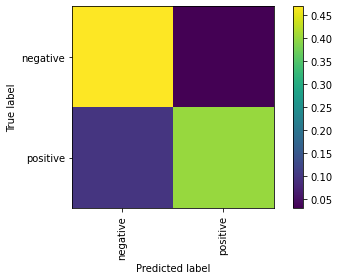

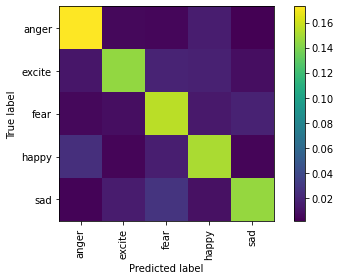

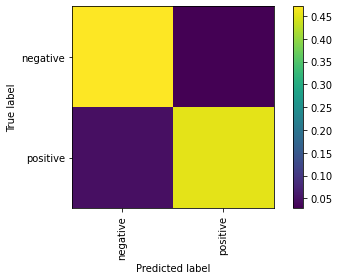

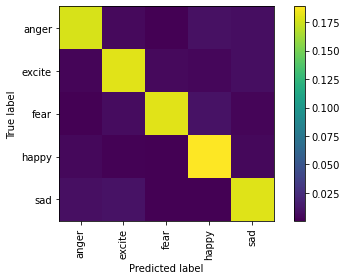

In [6]:
# train and test within one movie

for mov in ['DM', 'TP']:
    dataset = 'emo_movie{0}'.format(mov)
    
    #general emotions
    X_train = full_train[(full_train_labels['movie']==mov) & ((full_train_labels['cond']=='positive') | (full_train_labels['cond']=='negative'))]
    Y_train = full_train_labels['cond'][(full_train_labels['movie']==mov) & ((full_train_labels['cond']=='positive') | (full_train_labels['cond']=='negative'))]
    groups = full_train_labels['sub'][(full_train_labels['movie']==mov) & ((full_train_labels['cond']=='positive') | (full_train_labels['cond']=='negative'))]
    X_test = full_test[(full_test_labels['movie']==mov) & ((full_test_labels['cond']=='positive') | (full_test_labels['cond']=='negative'))]
    Y_test =full_test_labels['cond'][(full_test_labels['movie']==mov) & ((full_test_labels['cond']=='positive') | (full_test_labels['cond']=='negative'))]
    out_folder = out_dir+'general_data-{0}/'.format(dataset)

    svc = permutedSVM(model=model, cv=cv, output_folder=out_folder)
    svc = svc.fit(X_train, Y_train, groups)
    svc = svc.predict(X_test, Y_test)
    svc.boot_fit(ci=95, boot_samples=1000)
    #svc.boot_predict(ci=95, boot_samples=1000)
    svc.plot_confusion()
    #svc.calc_permuted_pvalue()
    
    #specific emotions
    X_train = full_train[(full_train_labels['movie']==mov) & ((full_train_labels['cond']=='anger') | (full_train_labels['cond']=='happy') | \
                          (full_train_labels['cond']=='sad') | (full_train_labels['cond']=='fear')| (full_train_labels['cond']=='excite'))]
    Y_train = full_train_labels['cond'][(full_train_labels['movie']==mov) & ((full_train_labels['cond']=='anger') | (full_train_labels['cond']=='happy') \
                                         | (full_train_labels['cond']=='sad') | (full_train_labels['cond']=='fear')| (full_train_labels['cond']=='excite'))]
    groups = full_train_labels['sub'][(full_train_labels['movie']==mov) & ((full_train_labels['cond']=='anger') | (full_train_labels['cond']=='happy') \
                                       | (full_train_labels['cond']=='sad') | (full_train_labels['cond']=='fear')| (full_train_labels['cond']=='excite'))]
    X_test = full_test[(full_test_labels['movie']==mov) & ((full_test_labels['cond']=='anger') | (full_test_labels['cond']=='happy') | \
                        (full_test_labels['cond']=='sad') | (full_test_labels['cond']=='fear')| (full_test_labels['cond']=='excite'))]
    Y_test =full_test_labels['cond'][(full_test_labels['movie']==mov) & ((full_test_labels['cond']=='anger') | (full_test_labels['cond']=='happy') \
                                      | (full_test_labels['cond']=='sad') | (full_test_labels['cond']=='fear')| (full_test_labels['cond']=='excite'))]
    out_folder = out_dir+'specific_data-{0}/'.format(dataset)

    svc = permutedSVM(model=model, cv=cv, output_folder=out_folder)
    svc = svc.fit(X_train, Y_train, groups)
    svc = svc.predict(X_test, Y_test)
    svc.boot_fit(ci=95, boot_samples=1000)
    #svc.boot_predict(ci=95, boot_samples=1000)
    svc.plot_confusion()
    #svc.calc_permuted_pvalue()

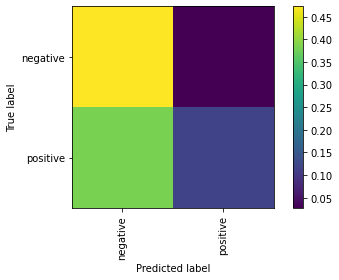

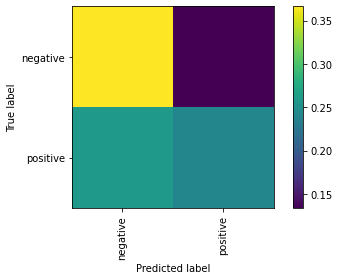

In [7]:
# train within one movie and test with the other (general).
dataset = 'emo_trainDMtestTP'

#set specific variables
X_train = full_train[(full_train_labels['movie']=='DM') & ((full_train_labels['cond']=='positive') | (full_train_labels['cond']=='negative'))]
Y_train = full_train_labels['cond'][(full_train_labels['movie']=='DM') & ((full_train_labels['cond']=='positive') | (full_train_labels['cond']=='negative'))]
groups = full_train_labels['sub'][(full_train_labels['movie']=='DM') & ((full_train_labels['cond']=='positive') | (full_train_labels['cond']=='negative'))]
X_test = full_test[(full_test_labels['movie']=='TP') & ((full_test_labels['cond']=='positive') | (full_test_labels['cond']=='negative'))]
Y_test =full_test_labels['cond'][(full_test_labels['movie']=='TP') & ((full_test_labels['cond']=='positive') | (full_test_labels['cond']=='negative'))]
out_folder = out_dir+'general_data-{0}/'.format(dataset)

svc = permutedSVM(model=model, cv=cv, output_folder=out_folder)
svc = svc.fit(X_train, Y_train, groups)
svc.boot_fit(ci=95, boot_samples=1000)
svc = svc.predict(X_test, Y_test)
#svc.boot_predict(ci=95, boot_samples=1000)
svc.plot_confusion()
#svc.calc_permuted_pvalue()


dataset = 'emo_trainTPtestDM'

#set specific variables
X_train = full_train[(full_train_labels['movie']=='TP') & ((full_train_labels['cond']=='positive') | (full_train_labels['cond']=='negative'))]
Y_train = full_train_labels['cond'][(full_train_labels['movie']=='TP') & ((full_train_labels['cond']=='positive') | (full_train_labels['cond']=='negative'))]
groups = full_train_labels['sub'][(full_train_labels['movie']=='TP') & ((full_train_labels['cond']=='positive') | (full_train_labels['cond']=='negative'))]
X_test = full_test[(full_test_labels['movie']=='DM') & ((full_test_labels['cond']=='positive') | (full_test_labels['cond']=='negative'))]
Y_test =full_test_labels['cond'][(full_test_labels['movie']=='DM') & ((full_test_labels['cond']=='positive') | (full_test_labels['cond']=='negative'))]
out_folder = out_dir+'general_data-{0}/'.format(dataset)

svc = permutedSVM(model=model, cv=cv, output_folder=out_folder)
svc = svc.fit(X_train, Y_train, groups)
svc = svc.predict(X_test, Y_test)
svc.boot_fit(ci=95, boot_samples=1000)
#svc.boot_predict(ci=95, boot_samples=1000)
svc.plot_confusion()
#svc.calc_permuted_pvalue()

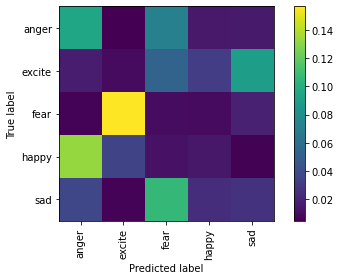

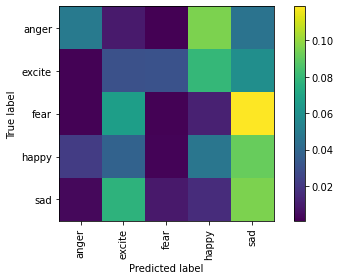

In [8]:
# train within one movie and test with the other (specific).
dataset = 'emo_trainDMtestTP'

#set specific variables
X_train = full_train[(full_train_labels['movie']=='DM') & ((full_train_labels['cond']=='anger') | (full_train_labels['cond']=='happy') | \
                      (full_train_labels['cond']=='sad') | (full_train_labels['cond']=='fear')| (full_train_labels['cond']=='excite'))]
Y_train = full_train_labels['cond'][(full_train_labels['movie']=='DM') & ((full_train_labels['cond']=='anger') | (full_train_labels['cond']=='happy') \
                                     | (full_train_labels['cond']=='sad') | (full_train_labels['cond']=='fear')| (full_train_labels['cond']=='excite'))]
groups = full_train_labels['sub'][(full_train_labels['movie']=='DM') & ((full_train_labels['cond']=='anger') | (full_train_labels['cond']=='happy') \
                                   | (full_train_labels['cond']=='sad') | (full_train_labels['cond']=='fear')| (full_train_labels['cond']=='excite'))]
X_test = full_test[(full_test_labels['movie']=='TP') & ((full_test_labels['cond']=='anger') | (full_test_labels['cond']=='happy') | \
                    (full_test_labels['cond']=='sad') | (full_test_labels['cond']=='fear')| (full_test_labels['cond']=='excite'))]
Y_test =full_test_labels['cond'][(full_test_labels['movie']=='TP') & ((full_test_labels['cond']=='anger') | (full_test_labels['cond']=='happy') \
                                  | (full_test_labels['cond']=='sad') | (full_test_labels['cond']=='fear')| (full_test_labels['cond']=='excite'))]
out_folder = out_dir+'specific_data-{0}/'.format(dataset)

svc = permutedSVM(model=model, cv=cv, output_folder=out_folder)
svc = svc.fit(X_train, Y_train, groups)
svc = svc.predict(X_test, Y_test)
#svc.boot_predict(ci=95, boot_samples=1000)
svc.boot_fit(ci=95, boot_samples=1000)
svc.plot_confusion()
#svc.calc_permuted_pvalue()

dataset = 'emo_trainTPtestDM'

#set specific variables
X_train = full_train[(full_train_labels['movie']=='TP') & ((full_train_labels['cond']=='anger') | (full_train_labels['cond']=='happy') | \
                      (full_train_labels['cond']=='sad') | (full_train_labels['cond']=='fear')| (full_train_labels['cond']=='excite'))]
Y_train = full_train_labels['cond'][(full_train_labels['movie']=='TP') & ((full_train_labels['cond']=='anger') | (full_train_labels['cond']=='happy') \
                                     | (full_train_labels['cond']=='sad') | (full_train_labels['cond']=='fear')| (full_train_labels['cond']=='excite'))]
groups = full_train_labels['sub'][(full_train_labels['movie']=='TP') & ((full_train_labels['cond']=='anger') | (full_train_labels['cond']=='happy') \
                                   | (full_train_labels['cond']=='sad') | (full_train_labels['cond']=='fear')| (full_train_labels['cond']=='excite'))]
X_test = full_test[(full_test_labels['movie']=='DM') & ((full_test_labels['cond']=='anger') | (full_test_labels['cond']=='happy') | \
                    (full_test_labels['cond']=='sad') | (full_test_labels['cond']=='fear')| (full_test_labels['cond']=='excite'))]
Y_test =full_test_labels['cond'][(full_test_labels['movie']=='DM') & ((full_test_labels['cond']=='anger') | (full_test_labels['cond']=='happy') \
                                  | (full_test_labels['cond']=='sad') | (full_test_labels['cond']=='fear')| (full_test_labels['cond']=='excite'))]
out_folder = out_dir+'specific_data-{0}/'.format(dataset)

svc = permutedSVM(model=model, cv=cv, output_folder=out_folder)
svc = svc.fit(X_train, Y_train, groups)
svc = svc.predict(X_test, Y_test)
#svc.boot_predict(ci=95, boot_samples=1000)
svc.boot_fit(ci=95, boot_samples=1000)
svc.plot_confusion()
#svc.calc_permuted_pvalue()

# Step 5: Compile Results

## Make a CSV with all stats 

In [14]:
results = pd.DataFrame(columns=['network','TrainAcc','TestAcc','TestLowerCI', 'TestUpperCI','TestPermPval'])
project_dir = '/Users/catcamacho/Library/CloudStorage/Box-Box/CCP/HBN_study/proc/group/'
out_dir = project_dir + 'SVM_results/thresh{0}/cond_analysis/'.format(thresh)

# full data
folders = os.listdir(out_dir)
for f in folders:
    if os.path.isfile('{0}{1}/performance_report.csv'.format(out_dir, f)):
        results.loc[f, 'TrainAcc'] = np.genfromtxt('{0}{1}/insample_accuracy.txt'.format(out_dir, f)) 
        t = pd.read_csv('{0}{1}/performance_report.csv'.format(out_dir, f), index_col=0)
        results.loc[f, 'TestAcc'] = t.loc['accuracy','precision']
        results.loc[f, 'network'] = 'NA'
    if os.path.isfile('{0}{1}/permutation_stats.csv'.format(out_dir, f)):
        permps = pd.read_csv('{0}{1}/permutation_stats.csv'.format(out_dir, f), index_col=0)
        results.loc[f, 'TestPermPval'] = permps.loc['Test_Score','PermPval']
    if os.path.isfile('{0}{1}/bootstrapped_test_accuracy_randN.csv'.format(out_dir, f)):
        t = pd.read_csv('{0}{1}/bootstrapped_test_accuracy_randN.csv'.format(out_dir, f), index_col=0)
        results.loc[f, 'TestLowerCI'] = t.loc['test_scores','lowerCI']
        results.loc[f, 'TestUpperCI'] = t.loc['test_scores','upperCI']
    if os.path.isfile('{0}{1}/bootstrapped_training_accuracy_randN.csv'.format(out_dir, f)):
        t = pd.read_csv('{0}{1}/bootstrapped_training_accuracy_randN.csv'.format(out_dir, f), index_col=0)
        results.loc[f, 'TrainLowerCI'] = t.loc['train_scores','lowerCI']
        results.loc[f, 'TrainUpperCI'] = t.loc['train_scores','upperCI']

# network/region-specific results
nets = os.listdir(out_dir + 'general_data-emo')
for net in nets:
    if os.path.isfile('{0}general_data-emo/{1}/performance_report.csv'.format(out_dir, net)): 
        t = pd.read_csv('{0}general_data-emo/{1}/performance_report.csv'.format(out_dir, net), index_col=0)
        results.loc['general_data-emo-'+net, 'TrainAcc'] = np.genfromtxt('{0}general_data-emo/{1}/insample_accuracy.txt'.format(out_dir, net))
        results.loc['general_data-emo-'+net, 'TestAcc'] = t.loc['accuracy','precision']
        results.loc['general_data-emo-'+net, 'network'] = net[3:]
    if os.path.isfile('{0}general_data-emo/{1}/permutation_stats.csv'.format(out_dir, net)):
        permps = pd.read_csv('{0}general_data-emo/{1}/permutation_stats.csv'.format(out_dir, net))
        results.loc['general_data-emo-'+net, 'TestPermPval'] = permps.loc['Test_Score','PermPval']
    if os.path.isfile('{0}general_data-emo/{1}/bootstrapped_test_accuracy_randN.csv'.format(out_dir, net)):
        t = pd.read_csv('{0}general_data-emo/{1}/bootstrapped_test_accuracy_randN.csv'.format(out_dir, net), index_col=0)
        results.loc['general_data-emo-'+net, 'TestLowerCI'] = t.loc['test_scores','lowerCI']
        results.loc['general_data-emo-'+net, 'TestUpperCI'] = t.loc['test_scores','upperCI']

# network/region-specific results
nets = os.listdir(out_dir + 'specific_data-emo')
for net in nets:
    if os.path.isfile('{0}specific_data-emo/{1}/performance_report.csv'.format(out_dir, net)): 
        t = pd.read_csv('{0}specific_data-emo/{1}/performance_report.csv'.format(out_dir, net), index_col=0)
        results.loc['specific_data-emo-'+net, 'TrainAcc'] = np.genfromtxt('{0}specific_data-emo/{1}/insample_accuracy.txt'.format(out_dir, net))
        results.loc['specific_data-emo-'+net, 'TestAcc'] = t.loc['accuracy','precision']
        results.loc['specific_data-emo-'+net, 'network'] = net[3:]
    if os.path.isfile('{0}specific_data-emo/{1}/permutation_stats.csv'.format(out_dir, net)):
        permps = pd.read_csv('{0}specific_data-emo/{1}/permutation_stats.csv'.format(out_dir, net))
        results.loc['specific_data-emo-'+net, 'TestPermPval'] = permps.loc['Test_Score','PermPval']
    if os.path.isfile('{0}specific_data-emo/{1}/bootstrapped_test_accuracy_randN.csv'.format(out_dir, net)):
        t = pd.read_csv('{0}specific_data-emo/{1}/bootstrapped_test_accuracy_randN.csv'.format(out_dir, net), index_col=0)
        results.loc['specific_data-emo-'+net, 'TestLowerCI'] = t.loc['test_scores','lowerCI']
        results.loc['specific_data-emo-'+net, 'TestUpperCI'] = t.loc['test_scores','upperCI']


results.to_csv(out_dir + 'compiled_results.csv')

## Plot network CIs

In [ ]:
gennet = results.iloc[3:24,:]
gennet = gennet.sort_values('network')
gennet['TestUpperCI'] = gennet['TestUpperCI']*100
gennet['TestLowerCI'] = gennet['TestLowerCI']*100
gennet['TestError'] = (gennet['TestUpperCI']-gennet['TestLowerCI'])/2
gennet['TestBootMeanAcc'] = gennet['TestLowerCI'] - gennet['TestError']
gennet = gennet.sort_values('TestBootMeanAcc', ascending=True)
gennet

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(context='talk', style='white')

fig, ax = plt.subplots(figsize=(8,8))
ax.errorbar(x=gennet['TestBootMeanAcc'], y=range(len(gennet['TestBootMeanAcc'])), xerr=gennet['TestError'], fmt='o', color='k')
plt.axvline(50, ls='--')
ax.set_yticks(range(0,len(gennet['network'])))
ax.set_yticklabels(gennet['network'].replace('None','TemporoVMPFC'))
ax.set_xlabel('Bootstrapped Accuracy (95% confidence)')
sns.despine()
plt.tight_layout()
plt.savefig('{0}general_data-emo/bootstrap_accuracy.svg'.format(out_dir))
plt.show()

In [ ]:
specnet = results.iloc[24:,:]
specnet = specnet.sort_values('network')
specnet['TestUpperCI'] = specnet['TestUpperCI']*100
specnet['TestLowerCI'] = specnet['TestLowerCI']*100
specnet['TestError'] = (specnet['TestUpperCI']-specnet['TestLowerCI'])/2
specnet['TestBootMeanAcc'] = specnet['TestLowerCI'] - specnet['TestError']
specnet = specnet.sort_values('TestBootMeanAcc', ascending=True)
specnet

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))
ax.errorbar(x=specnet['TestBootMeanAcc'], y=range(len(specnet['TestBootMeanAcc'])), xerr=specnet['TestError'], fmt='o', color='k')
plt.axvline(20, ls='--') 
ax.set_yticks(range(0,len(specnet['network'])))
ax.set_yticklabels(specnet['network'].replace('None','TemporoVMPFC'))
ax.set_xlabel('Bootstrapped Accuracy (95% confidence)')
sns.despine()
plt.tight_layout()
plt.savefig('{0}specific_data-emo/bootstrap_accuracy.svg'.format(out_dir))
plt.show()